In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
from functools import partial # reduces arguments to function by making some subset implicit

from jax.experimental import stax
from jax.experimental import optimizers

# visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from moviepy.editor import ImageSequenceClip
from functools import partial
import proglog
from PIL import Image

### Make sure we're using a GPU

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [3]:
def lagrangian(q, q_dot, m1, m2, l1, l2, g):
  t1, t2 = q     # theta 1 and theta 2
  w1, w2 = q_dot # omega 1 and omega 2

  # kinetic energy (T)
  T1 = 0.5 * m1 * (l1 * w1)**2
  T2 = 0.5 * m2 * ((l1 * w1)**2 + (l2 * w2)**2 +
                    2 * l1 * l2 * w1 * w2 * jnp.cos(t1 - t2))
  T = T1 + T2
  
  # potential energy (V)
  y1 = -l1 * jnp.cos(t1)
  y2 = y1 - l2 * jnp.cos(t2)
  V = m1 * g * y1 + m2 * g * y2

  return T - V

In [4]:
def f_analytical(state, t=0, m1=1, m2=1, l1=1, l2=1, g=9.8):
  t1, t2, w1, w2 = state
  a1 = (l2 / l1) * (m2 / (m1 + m2)) * jnp.cos(t1 - t2)
  a2 = (l1 / l2) * jnp.cos(t1 - t2)
  f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w2**2) * jnp.sin(t1 - t2) - \
      (g / l1) * jnp.sin(t1)
  f2 = (l1 / l2) * (w1**2) * jnp.sin(t1 - t2) - (g / l2) * jnp.sin(t2)
  g1 = (f1 - a1 * f2) / (1 - a1 * a2)
  g2 = (f2 - a2 * f1) / (1 - a1 * a2)
  return jnp.stack([w1, w2, g1, g2])

In [5]:
def equation_of_motion(lagrangian, state, t=None):
  q, q_t = jnp.split(state, 2)
  q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
  return jnp.concatenate([q_t, q_tt])

def solve_lagrangian(lagrangian, initial_state, **kwargs):
  # We currently run odeint on CPUs only, because its cost is dominated by
  # control flow, which is slow on GPUs.
  @partial(jax.jit, backend='cpu')
  def f(initial_state):
    return odeint(partial(equation_of_motion, lagrangian),
                  initial_state, **kwargs)
  return f(initial_state)

In [6]:
# Double pendulum dynamics via the rewritten Euler-Lagrange
@partial(jax.jit, backend='cpu')
def solve_autograd(initial_state, times, m1=1, m2=1, l1=1, l2=1, g=9.8):
  L = partial(lagrangian, m1=m1, m2=m2, l1=l1, l2=l2, g=g)
  return solve_lagrangian(L, initial_state, t=times, rtol=1e-10, atol=1e-10)

# Double pendulum dynamics via analytical forces taken from Diego's blog
@partial(jax.jit, backend='cpu')
def solve_analytical(initial_state, times):
  return odeint(f_analytical, initial_state, t=times, rtol=1e-10, atol=1e-10)

def normalize_dp(state):
  # wrap generalized coordinates to [-pi, pi]
  return jnp.concatenate([(state[:2] + np.pi) % (2 * np.pi) - np.pi, state[2:]])

def rk4_step(f, x, t, h):
  # one step of runge-kutta integration
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [7]:
# choose an initial state
x0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
noise = np.random.RandomState(0).randn(x0.size)
t = np.linspace(0, 40, num=401, dtype=np.float32)

In [8]:
# compute dynamics analytically
%time x_analytical = jax.device_get(solve_analytical(x0, t))
noise_coeff_1, noise_coeff_2 = 1e-10, 1e-11
x_perturbed_1 = jax.device_get(solve_analytical(x0 + noise_coeff_1 * noise, t))
x_perturbed_2 = jax.device_get(solve_analytical(x0 + noise_coeff_2 * noise, t))

CPU times: user 871 ms, sys: 17.9 ms, total: 889 ms
Wall time: 862 ms


In [9]:
# compute dynamics via autograd / the rewritten E-L equation
%time x_autograd = jax.device_get(solve_autograd(x0, t))

CPU times: user 2.52 s, sys: 2.72 ms, total: 2.52 s
Wall time: 2.57 s


### Plot a comparison

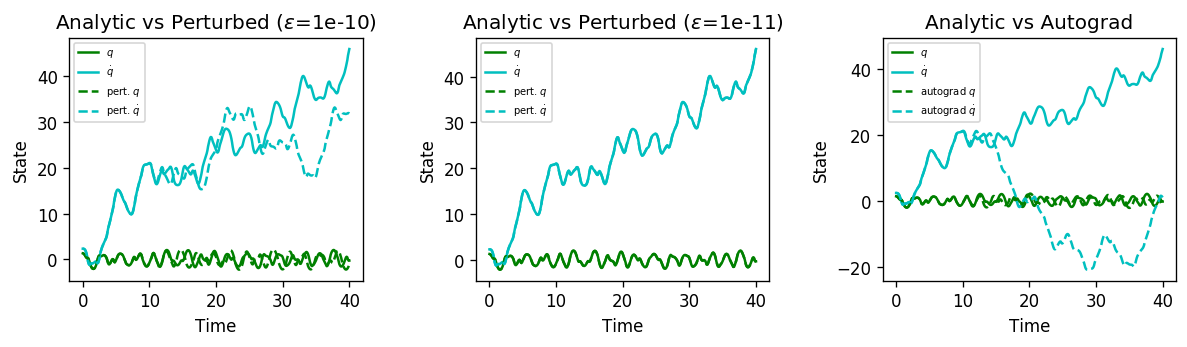

In [ ]:
plt.figure(figsize=[10,3], dpi=120) ; plt.xlim(0, 100)
plt.subplot(1,3,1)
plt.title("Analytic vs Perturbed ($\epsilon$={})".format(noise_coeff_1))
plt.xlabel("Time") ; plt.ylabel("State")
plt.plot(t, x_analytical[:, 0], 'g-', label='$q$')
plt.plot(t, x_analytical[:, 1], 'c-', label='$\dot q$')
plt.plot(t, x_perturbed_1[:, 0], 'g--', label='pert. $q$')
plt.plot(t, x_perturbed_1[:, 1], 'c--', label='pert. $\dot q$')
plt.legend(fontsize=6)

plt.subplot(1,3,2)
plt.title("Analytic vs Perturbed ($\epsilon$={})".format(noise_coeff_2))
plt.xlabel("Time") ; plt.ylabel("State")
plt.plot(t, x_analytical[:, 0], 'g-', label='$q$')
plt.plot(t, x_analytical[:, 1], 'c-', label='$\dot q$')
plt.plot(t, x_perturbed_2[:, 0], 'g--', label='pert. $q$')
plt.plot(t, x_perturbed_2[:, 1], 'c--', label='pert. $\dot q$')
plt.legend(fontsize=6)

plt.subplot(1,3,3)
plt.title("Analytic vs Autograd")
plt.xlabel("Time") ; plt.ylabel("State")
plt.plot(t, x_analytical[:, 0], 'g-', label='$q$')
plt.plot(t, x_analytical[:, 1], 'c-', label='$\dot q$')
plt.plot(t, x_autograd[:, 0], 'g--', label='autograd $q$')
plt.plot(t, x_autograd[:, 1], 'c--', label='autograd $\dot q$')
plt.legend(fontsize=6)

plt.tight_layout() ; plt.show()

In [10]:
time_step = 0.01
N = 1500
analytical_step = jax.jit(jax.vmap(partial(rk4_step, f_analytical, t=0.0, h=time_step)))

# x0 = np.array([-0.3*np.pi, 0.2*np.pi, 0.35*np.pi, 0.5*np.pi], dtype=np.float32)
x0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
t = np.arange(N, dtype=np.float32) # time steps 0 to N
%time x_train = jax.device_get(solve_analytical(x0, t)) # dynamics for first N time steps
%time xt_train = jax.device_get(jax.vmap(f_analytical)(x_train)) # time derivatives of each state
%time y_train = jax.device_get(analytical_step(x_train)) # analytical next step

noise = np.random.RandomState(0).randn(x0.size)
t_test = np.arange(N, 2*N, dtype=np.float32) # time steps N to 2N
%time x_test = jax.device_get(solve_analytical(x0, t_test)) # dynamics for next N time steps
%time xt_test = jax.device_get(jax.vmap(f_analytical)(x_test)) # time derivatives of each state
%time y_test = jax.device_get(analytical_step(x_test)) # analytical next step


CPU times: user 7.6 s, sys: 1.47 ms, total: 7.6 s
Wall time: 7.54 s
CPU times: user 495 ms, sys: 211 ms, total: 706 ms
Wall time: 1.6 s
CPU times: user 855 ms, sys: 877 µs, total: 856 ms
Wall time: 1.15 s
CPU times: user 6.62 s, sys: 23.8 ms, total: 6.64 s
Wall time: 6.59 s
CPU times: user 25.3 ms, sys: 71 µs, total: 25.4 ms
Wall time: 19.9 ms
CPU times: user 895 µs, sys: 57 µs, total: 952 µs
Wall time: 517 µs


### Visualize train and test data

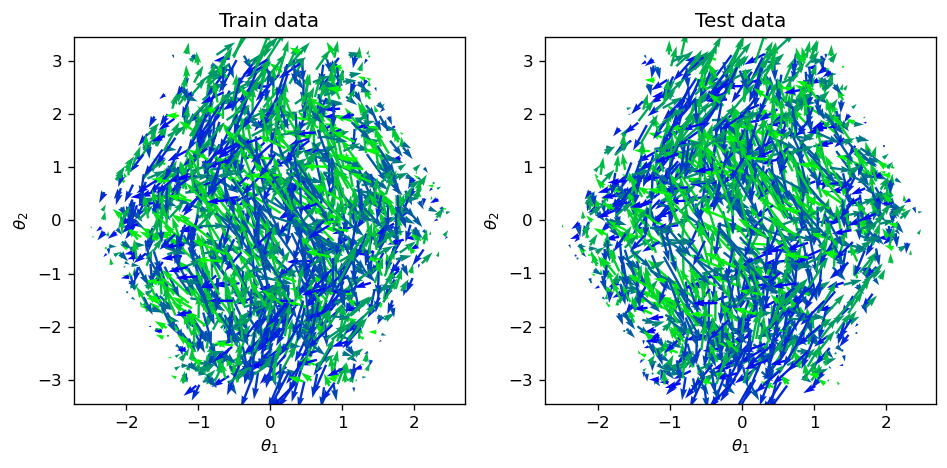

In [11]:
# preprocess
train_vis = jax.vmap(normalize_dp)(x_train)
test_vis = jax.vmap(normalize_dp)(x_test)

vel_angle = lambda data:  (np.arctan2(data[:,3], data[:,2]) / np.pi + 1)/2
vel_color = lambda vangle: np.stack( [np.zeros_like(vangle), vangle, 1-vangle]).T
train_colors = vel_color(vel_angle(train_vis))
test_colors = vel_color(vel_angle(test_vis))

# plot
SCALE = 80 ; WIDTH = 0.006
plt.figure(figsize=[8,4], dpi=120)
plt.subplot(1,2,1)
plt.title("Train data") ; plt.xlabel(r'$\theta_1$') ; plt.ylabel(r'$\theta_2$')
plt.quiver(*train_vis.T, color=train_colors, scale=SCALE, width=WIDTH)

plt.subplot(1,2,2)
plt.title("Test data") ; plt.xlabel(r'$\theta_1$') ; plt.ylabel(r'$\theta_2$')
plt.quiver(*test_vis.T, color=test_colors, scale=SCALE, width=WIDTH)

plt.tight_layout() ; plt.show()

## **Step 6: Build a Lagrangian Neural Network**
This section presents a bare-bones approach to approximating the Lagrangian with a neural network

### i) Build model and define the loss


In [12]:
# replace the lagrangian with a parameteric model
def learned_lagrangian(params):
  def lagrangian(q, q_t):
    assert q.shape == (2,)
    state = normalize_dp(jnp.concatenate([q, q_t]))
    return jnp.squeeze(nn_forward_fn(params, state), axis=-1)
  return lagrangian

# define the loss of the model (MSE between predicted q, \dot q and targets)
@jax.jit
def loss(params, batch, time_step=None):
  state, targets = batch
  if time_step is not None:
    f = partial(equation_of_motion, learned_lagrangian(params))
    preds = jax.vmap(partial(rk4_step, f, t=0.0, h=time_step))(state)
  else:
    preds = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(state)
  return jnp.mean((preds - targets) ** 2)

# build a neural network model
init_random_params, nn_forward_fn = stax.serial(
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(1),
)

### ii) Define optimization and data

In [13]:
@jax.jit
def update_timestep(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, time_step), opt_state)

@jax.jit
def update_derivative(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, None), opt_state)

x_train = jax.device_put(jax.vmap(normalize_dp)(x_train))
y_train = jax.device_put(y_train)

x_test = jax.device_put(jax.vmap(normalize_dp)(x_test))
y_test = jax.device_put(y_test)

### iii) Train the model

In [14]:
%%time

rng = jax.random.PRNGKey(0)
_, init_params = init_random_params(rng, (-1, 4))

# numbers in comments denote stephan's settings
batch_size = 100
test_every = 10
num_batches = 1500

train_losses = []
test_losses = []

# adam w learn rate decay
opt_init, opt_update, get_params = optimizers.adam(
    lambda t: jnp.select([t < batch_size*(num_batches//3),
                          t < batch_size*(2*num_batches//3),
                          t > batch_size*(2*num_batches//3)],
                         [1e-3, 3e-4, 1e-4]))
opt_state = opt_init(init_params)

for iteration in range(batch_size*num_batches + 1):
  if iteration % batch_size == 0:
    params = get_params(opt_state)
    train_loss = loss(params, (x_train, xt_train))
    train_losses.append(train_loss)
    test_loss = loss(params, (x_test, xt_test))
    test_losses.append(test_loss)
    if iteration % (batch_size*test_every) == 0:
      print(f"iteration={iteration}, train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")
  opt_state = update_derivative(iteration, opt_state, (x_train, xt_train))

params = get_params(opt_state)

iteration=0, train_loss=1862.420288, test_loss=382.681793
iteration=1000, train_loss=99.708481, test_loss=104.769600
iteration=2000, train_loss=46.728374, test_loss=47.235016
iteration=3000, train_loss=21.319921, test_loss=21.289379
iteration=4000, train_loss=8.596034, test_loss=8.900611
iteration=5000, train_loss=4.534757, test_loss=4.896561
iteration=6000, train_loss=2.781838, test_loss=3.140072
iteration=7000, train_loss=2.287088, test_loss=2.587027
iteration=8000, train_loss=3.278694, test_loss=3.598329
iteration=9000, train_loss=2.626771, test_loss=2.737609
iteration=10000, train_loss=2.240497, test_loss=2.325275
iteration=11000, train_loss=1.998316, test_loss=2.095319
iteration=12000, train_loss=1.339793, test_loss=1.486351
iteration=13000, train_loss=1.057567, test_loss=1.180095
iteration=14000, train_loss=1.019150, test_loss=1.110738
iteration=15000, train_loss=1.202938, test_loss=1.235930
iteration=16000, train_loss=0.741707, test_loss=0.824240
iteration=17000, train_loss=0.69

iteration=143000, train_loss=0.002449, test_loss=0.005431
iteration=144000, train_loss=0.002371, test_loss=0.005433
iteration=145000, train_loss=0.002278, test_loss=0.005281
iteration=146000, train_loss=0.002925, test_loss=0.005921
iteration=147000, train_loss=0.009280, test_loss=0.011187
iteration=148000, train_loss=0.005091, test_loss=0.007494
iteration=149000, train_loss=0.002193, test_loss=0.005108
iteration=150000, train_loss=0.002172, test_loss=0.005058
CPU times: user 6min 38s, sys: 2min 15s, total: 8min 54s
Wall time: 8min 16s


### iv) Plot losses over training

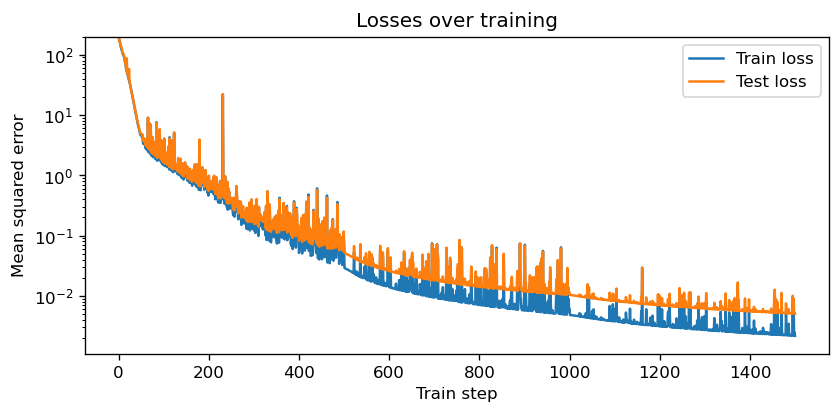

In [16]:
plt.figure(figsize=(8, 3.5), dpi=120)
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.yscale('log')
plt.ylim(None, 200)
plt.title('Losses over training')
plt.xlabel("Train step") ; plt.ylabel("Mean squared error")
plt.legend() ; plt.show()

## **Step 7: Visualize what the model has learned**
In this section we'll run some basic sanity checks to see whether the model has learned something that resembles the Lagrangian of the system

### i) Plot predicted vs actual coordinates (we want a 1:1 mapping)


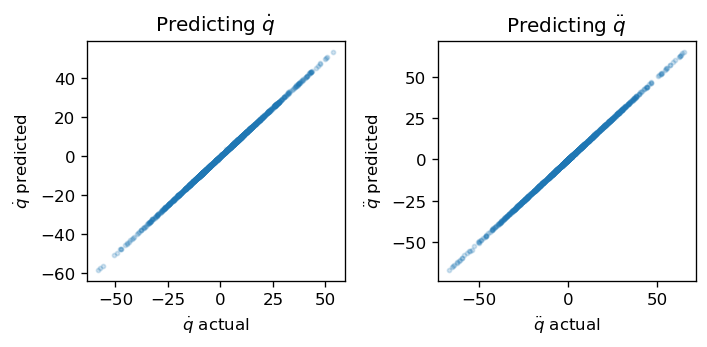

In [17]:
xt_pred = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(x_test)

fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=120)
axes[0].scatter(xt_test[:, 2], xt_pred[:, 2], s=6, alpha=0.2)
axes[0].set_title('Predicting $\dot q$')
axes[0].set_xlabel('$\dot q$ actual')
axes[0].set_ylabel('$\dot q$ predicted')
axes[1].scatter(xt_test[:, 3], xt_pred[:, 3], s=6, alpha=0.2)
axes[1].set_title('Predicting $\ddot q$')
axes[1].set_xlabel('$\ddot q$ actual')
axes[1].set_ylabel('$\ddot q$ predicted')
plt.tight_layout()

### ii) Examine the model's performance over the full coordinate space

In [18]:
# make a meshgrid of possible angles
angle_range = -np.pi + 2 * np.pi * np.arange(100)/100
x_scanned = np.stack(np.meshgrid(angle_range, angle_range, [0.0], [0.0], indexing='ij'), axis=-1).reshape(-1, 4)

In [19]:
%time xt_actual = jax.vmap(f_analytical)(x_scanned) # actual time derivatives

CPU times: user 357 ms, sys: 96.8 ms, total: 454 ms
Wall time: 1.35 s


In [20]:
%time xt_predicted = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(x_scanned) # predicted time derivatives

CPU times: user 3.81 s, sys: 503 ms, total: 4.32 s
Wall time: 7.71 s


In [21]:
import xarray
dataarray = xarray.DataArray(np.stack([xt_actual.reshape(100, 100, 4),
                                       xt_predicted.reshape(100, 100, 4)]),
                             dims=['model', 'theta1', 'theta2', 'time_derivative'],
                             coords={'model': ['actual', 'predicted'], 'theta1': angle_range, 'theta2': angle_range})

Colorscale is \dot theta1


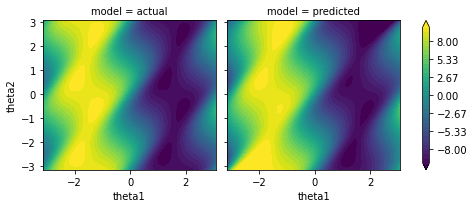

In [22]:
dataarray.isel(time_derivative=2).plot.contourf(levels=31, col='model', x='theta1', y='theta2', vmin=-10, vmax=10)
print("Colorscale is \dot theta1")
plt.show()

Colorscale is \dot theta2


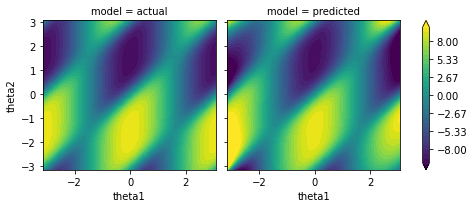

In [23]:
dataarray.isel(time_derivative=3).plot.contourf(levels=31, col='model', x='theta1', y='theta2', vmin=-10, vmax=10)
print("Colorscale is \dot theta2")
plt.show()

## **Step 8: Make predictions with the model**
We should be able to simulate the double pendulum with reasonable degree of accuracy.

In [24]:
# choose an initial state
x1 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)

t2 = np.linspace(0, 20, num=301)
%time x1_analytical = jax.device_get(solve_analytical(x1, t2))
noise_coeff_3 = 1e-3
%time x1_perturbed = jax.device_get(solve_analytical(x1 + noise_coeff_3 * noise, t2))
%time x1_model = jax.device_get(solve_lagrangian(learned_lagrangian(params), x1, t=t2))

CPU times: user 954 ms, sys: 7.02 ms, total: 961 ms
Wall time: 950 ms
CPU times: user 12.9 ms, sys: 254 µs, total: 13.2 ms
Wall time: 12.7 ms
CPU times: user 5.54 s, sys: 65.6 ms, total: 5.6 s
Wall time: 5.55 s


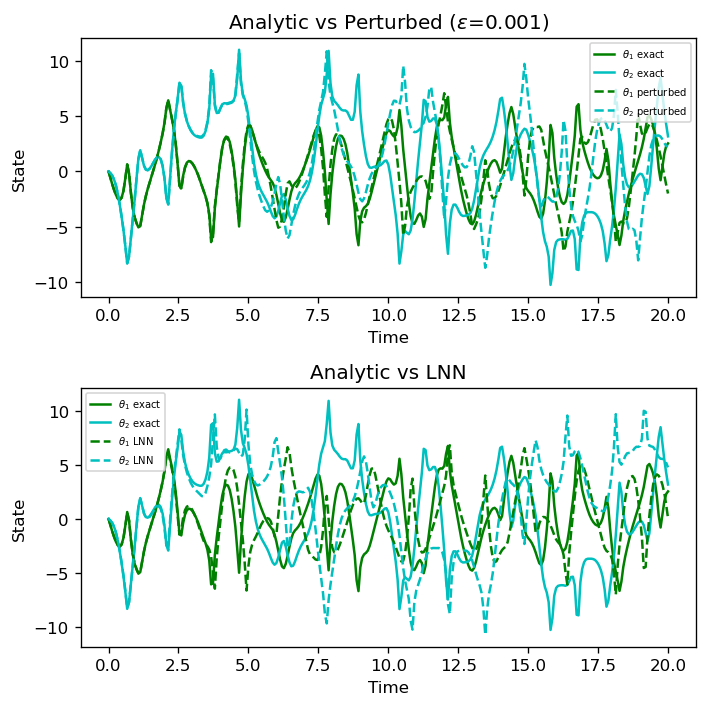

In [25]:
plt.figure(figsize=[6,6], dpi=120) ; plt.xlim(0, 20)
plt.subplot(2,1,1)
plt.title("Analytic vs Perturbed ($\epsilon$={})".format(noise_coeff_3))
plt.xlabel("Time") ; plt.ylabel("State")
plt.plot(t2, x1_analytical[:, 2], 'g-', label=r'$\theta_1$ exact')
plt.plot(t2, x1_analytical[:, 3], 'c-', label=r'$\theta_2$ exact')
plt.plot(t2, x1_perturbed[:, 2], 'g--', label=r'$\theta_1$ perturbed')
plt.plot(t2, x1_perturbed[:, 3], 'c--', label=r'$\theta_2$ perturbed')
plt.legend(fontsize=6)

plt.subplot(2,1,2)
plt.title("Analytic vs LNN")
plt.xlabel("Time") ; plt.ylabel("State")
plt.plot(t2, x1_analytical[:, 2], 'g-', label=r'$\theta_1$ exact')
plt.plot(t2, x1_analytical[:, 3], 'c-', label=r'$\theta_2$ exact')
plt.plot(t2, x1_model[:, 2], 'g--', label=r'$\theta_1$ LNN')
plt.plot(t2, x1_model[:, 3], 'c--', label=r'$\theta_2$ LNN')
plt.legend(fontsize=6)

plt.tight_layout() ; plt.show()

## **Step 9: Make videos of the system**

We'll use these to get an intuitive sense of how well our model has learned the dynamics

### i) First, we need to define functions for plotting the pendulum
Sam used [this scipy tutorial](https://scipython.com/blog/the-double-pendulum/) and Stephan Hoyer's [wave equation demo for Jax on TPU](https://colab.research.google.com/github/google/jax/blob/master/cloud_tpu_colabs/Wave_Equation.ipynb) to write the following code.

In [26]:
def make_plot(i, cart_coords, l1, l2, max_trail=30, trail_segments=20, r = 0.05):
    # Plot and save an image of the double pendulum configuration for time step i.
    plt.cla()

    x1, y1, x2, y2 = cart_coords
    ax.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], lw=2, c='k') # rods
    c0 = Circle((0, 0), r/2, fc='k', zorder=10) # anchor point
    c1 = Circle((x1[i], y1[i]), r, fc='b', ec='b', zorder=10) # mass 1
    c2 = Circle((x2[i], y2[i]), r, fc='r', ec='r', zorder=10) # mass 2
    ax.add_patch(c0)
    ax.add_patch(c1)
    ax.add_patch(c2)

    # plot the pendulum trail (ns = number of segments)
    s = max_trail // trail_segments
    for j in range(trail_segments):
        imin = i - (trail_segments-j)*s
        if imin < 0: continue
        imax = imin + s + 1
        alpha = (j/trail_segments)**2 # fade the trail into alpha
        ax.plot(x2[imin:imax], y2[imin:imax], c='r', solid_capstyle='butt',
                lw=2, alpha=alpha)

    # Center the image on the fixed anchor point. Make axes equal.
    ax.set_xlim(-l1-l2-r, l1+l2+r)
    ax.set_ylim(-l1-l2-r, l1+l2+r)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    # plt.savefig('./frames/_img{:04d}.png'.format(i//di), dpi=72)

def radial2cartesian(t1, t2, l1, l2):
  # Convert from radial to Cartesian coordinates.
  x1 = l1 * np.sin(t1)
  y1 = -l1 * np.cos(t1)
  x2 = x1 + l2 * np.sin(t2)
  y2 = y1 - l2 * np.cos(t2)
  return x1, y1, x2, y2

def fig2image(fig):
  fig.canvas.draw()
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
  image = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  return image

In [40]:
L1, L2 = 1, 1
theta1mod, theta2mod = x1_model[:, 0], x1_model[:, 1]
cart_coords_mod = radial2cartesian(theta1mod, theta2mod, L1, L2)

L1, L2 = 1, 1
theta1ana, theta2ana = x1_analytical[:, 0], x1_analytical[:, 1]
cart_coords_ana = radial2cartesian(theta1ana, theta2ana, L1, L2)

### ii) Next, we'll make a movie of the pendulum's analytic dynamics

0/300
1/300 2/300 3/300 4/300 5/300 6/300 7/300 8/300 9/300 10/300 11/300 12/300 13/300 14/300 15/300 16/300 17/300 18/300 19/300 20/300
21/300 22/300 23/300 24/300 25/300 26/300 27/300 28/300 29/300 30/300 31/300 32/300 33/300 34/300 35/300 36/300 37/300 38/300 39/300 40/300
41/300 42/300 43/300 44/300 45/300 46/300 47/300 48/300 49/300 50/300 51/300 52/300 53/300 54/300 55/300 56/300 57/300 58/300 59/300 60/300
61/300 62/300 63/300 64/300 65/300 66/300 67/300 68/300 69/300 70/300 71/300 72/300 73/300 74/300 75/300 76/300 77/300 78/300 79/300 80/300
81/300 82/300 83/300 84/300 85/300 86/300 87/300 88/300 89/300 90/300 91/300 92/300 93/300 94/300 95/300 96/300 97/300 98/300 99/300 100/300
101/300 102/300 103/300 104/300 105/300 106/300 107/300 108/300 109/300 110/300 111/300 112/300 113/300 114/300 115/300 116/300 117/300 118/300 119/300 120/300
121/300 122/300 123/300 124/300 125/300 126/300 127/300 128/300 129/300 130/300 131/300 132/300 133/300 134/300 135/300 136/300 137/300 138/30

Moviepy - Done !
Moviepy - video ready DoublePendulumModelMotion.mp4


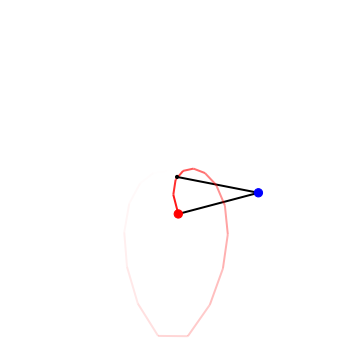

In [28]:
fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

import warnings
warnings.filterwarnings("ignore")

images = []
di = 1
N = 300
for i in range(0, N, di):
  print("{}/{}".format(i // di, N // di), end='\n' if i//di%20==0 else ' ')
  make_plot(i, cart_coords, 1, 1)
  images.append( fig2image(fig) )

analytical_clip = ImageSequenceClip(images, fps=25)
analytical_clip.write_videofile("DoublePendulumModelMotion.mp4")

0/300
1/300 2/300 3/300 4/300 5/300 6/300 7/300 8/300 9/300 10/300 11/300 12/300 13/300 14/300 15/300 16/300 17/300 18/300 19/300 20/300
21/300 22/300 23/300 24/300 25/300 26/300 27/300 28/300 29/300 30/300 31/300 32/300 33/300 34/300 35/300 36/300 37/300 38/300 39/300 40/300
41/300 42/300 43/300 44/300 45/300 46/300 47/300 48/300 49/300 50/300 51/300 52/300 53/300 54/300 55/300 56/300 57/300 58/300 59/300 60/300
61/300 62/300 63/300 64/300 65/300 66/300 67/300 68/300 69/300 70/300 71/300 72/300 73/300 74/300 75/300 76/300 77/300 78/300 79/300 80/300
81/300 82/300 83/300 84/300 85/300 86/300 87/300 88/300 89/300 90/300 91/300 92/300 93/300 94/300 95/300 96/300 97/300 98/300 99/300 100/300
101/300 102/300 103/300 104/300 105/300 106/300 107/300 108/300 109/300 110/300 111/300 112/300 113/300 114/300 115/300 116/300 117/300 118/300 119/300 120/300
121/300 122/300 123/300 124/300 125/300 126/300 127/300 128/300 129/300 130/300 131/300 132/300 133/300 134/300 135/300 136/300 137/300 138/30

Moviepy - Done !
Moviepy - video ready DoublePendulumAnalyticMotion.mp4


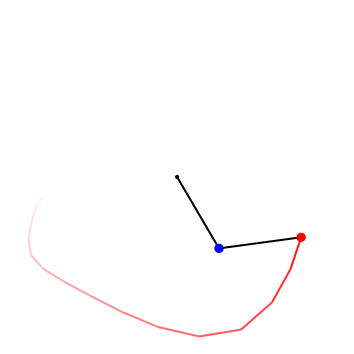

In [29]:
fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

import warnings
warnings.filterwarnings("ignore")

images = []
di = 1
N = 300
for i in range(0, N, di):
  print("{}/{}".format(i // di, N // di), end='\n' if i//di%20==0 else ' ')
  make_plot(i, cart_coords, 1, 1)
  images.append( fig2image(fig) )

analytical_clip = ImageSequenceClip(images, fps=25)
analytical_clip.write_videofile("DoublePendulumAnalyticMotion.mp4")

In [93]:
def cart_coords_over_time(cart_coords):
    x1, y1, x2, y2 = cart_coords
    
    length = len(x2)
    t = np.arange(length)
    
    plt.title("Analytic Double Pendulum " + f"Timeseries - {length - 1} timesteps")

    plt.plot(x2, y2, marker='.', color="lightgray", zorder=0)
    plt.scatter(x2, y2, marker='o', c=t[:length], cmap="viridis", s=10, zorder=1)

    plt.xlabel("$x$")
    plt.ylabel("$y$")

    cbar = plt.colorbar()
    cbar.ax.set_ylabel('$t$', rotation=270)

    #plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.show()

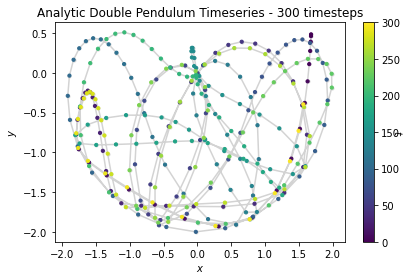

In [94]:
cart_coords_over_time(cart_coords_ana)

In [53]:
def cart_error_over_time(cart_coords_model, cart_coords_ana):
    x11, y11, x21, y21 = cart_coords_ana
    x12, y12, x22, y22 = cart_coords_model
    
    distance_1 = np.sqrt((np.square(np.absolute(x11 - x12)) + np.square(np.absolute(y11 - y12))))
    distance_2 = np.sqrt((np.square(np.absolute(x21 - x22)) + np.square(np.absolute(y21 - y22))))
    
    index = np.arange(np.size(distance_1))
    
    plt.plot(index, distance_1, label='first pendulum arm')
    plt.plot(index, distance_2, label='second pendulum arm')
    plt.legend(loc="upper right")
    
    plt.title('Error Over Time by Distance')
    plt.xlabel('Timestep')
    plt.ylabel('Distance')

    plt.show()

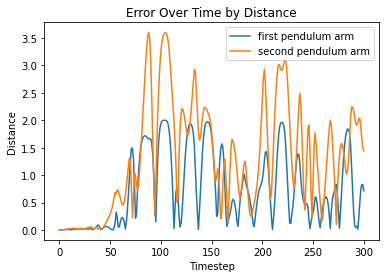

In [54]:
cart_error_over_time(cart_coords_mod, cart_coords_ana)

In [57]:
def theta_error_over_time(theta1_model, theta2_model, theta1_ana, theta2_ana):
    distance_1 = theta1_model - theta1_ana
    distance_2 = theta2_model - theta2_ana
    
    index = np.arange(np.size(distance_1))
    
    plt.plot(index, distance_1, label='first pendulum arm')
    plt.plot(index, distance_2, label='second pendulum arm')
    plt.legend(loc="upper left")
    
    plt.title('Error Over Time by Angle')
    plt.xlabel('Timestep')
    plt.ylabel('Angle (radians)')

    plt.show()

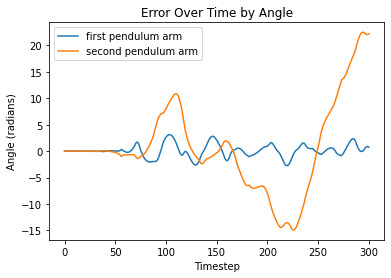

In [58]:
theta_error_over_time(theta1mod, theta2mod, theta1ana, theta2ana)